In [85]:
%load_ext autoreload
%autoreload 2
%matplotlib qt5
# Add modules to the path
import sys
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos')

import joypy
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.signal import decimate
from utils.plotting import HeatMapParams
from utils.plotting import heat_map_and_mean, plot_one_side, calculate_error_bars
from utils.plotting import get_photometry_around_event
from scipy import stats
from utils.individual_trial_analysis_utils import ZScoredTraces, SessionData, CueAlignedData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
mouse = 'SNL_photo21'
date = '20200911'
saving_folder = 'W:\\photometry_2AC\\processed_data\\' + mouse + '\\'
restructured_data_filename = mouse + '_' + date + '_' + 'restructured_data.pkl'
trial_data = pd.read_pickle(saving_folder + restructured_data_filename) 

In [67]:
demod_signal = np.load(saving_folder + mouse + '_' + date + "_smoothed_signal.npy" )

In [68]:
plt.plot(demod_signal)

In [78]:
demod_signal.shape

(43985000,)

In [112]:
class CustomAlignedData(object):
    def __init__(self, session_data, params):
        saving_folder = 'W:\\photometry_2AC\\processed_data\\' + session_data.mouse + '\\'
        restructured_data_filename = session_data.mouse + '_' + session_data.date + '_' + 'restructured_data.pkl'
        trial_data = pd.read_pickle(saving_folder + restructured_data_filename)
        dff_trace_filename = session_data.mouse + '_' + session_data.date + '_' + 'smoothed_signal.npy'
        dff = np.load(saving_folder + dff_trace_filename)

        fiber_options = np.array(['left', 'right'])
        fiber_side_numeric = (np.where(fiber_options == session_data.fiber_side)[0] + 1)[0]
        contra_fiber_side_numeric = (np.where(fiber_options != session_data.fiber_side)[0] + 1)[0]

        self.ipsi_data = ZScoredTraces(trial_data, dff, params, fiber_side_numeric, fiber_side_numeric)
        self.ipsi_data.get_peaks()
        self.contra_data = ZScoredTraces(trial_data, dff,params, contra_fiber_side_numeric, contra_fiber_side_numeric)
        self.contra_data.get_peaks()

In [3]:
def get_all_experimental_records():
    experiment_record = pd.read_csv('W:\\photometry_2AC\\experimental_record.csv')
    experiment_record['date'] = experiment_record['date'].astype(str)
    return experiment_record

In [4]:
def open_experiment(experiment_to_add):
    for index, experiment in experiment_to_add.iterrows():
        saving_folder = 'W:\\photometry_2AC\\processed_data\\' + experiment['mouse_id'] + '\\'
        restructured_data_filename = experiment['mouse_id'] + '_' + experiment['date'] + '_' + 'restructured_data.pkl'
        trial_data = pd.read_pickle(saving_folder + restructured_data_filename)
        dff_trace_filename = experiment['mouse_id'] + '_' + experiment['date'] + '_' + 'smoothed_signal.npy'
        dff = np.load(saving_folder + dff_trace_filename)
        session_traces = SessionData(experiment['fiber_side'], experiment['recording_site'], experiment['mouse_id'], experiment['date'])
    return session_traces

In [165]:
mouse_id = 'SNL_photo26'
date = '20200915'
all_experiments = get_all_experimental_records()
experiment_to_process = all_experiments[(all_experiments['date'] == date) & (all_experiments['mouse_id'] == mouse_id)]
session_data = open_experiment(experiment_to_process)

In [166]:
    params = {'state_type_of_interest': 5,
        'outcome': 2,
        'last_outcome': 0,  # NOT USED CURRENTLY
        'no_repeats' : 1,
        'last_response': 0,
        'align_to' : 'Time start',
        'instance': 1,
        'plot_range': [-6, 6],
        'first_choice_correct': 0,
         'cue': 'None'}
test = CustomAlignedData(session_data, params)

(305, 160000)
(278, 160000)


In [167]:
trials_pre_state_change = np.where(test.contra_data.trial_nums <=150)[0]
trials_post_state_change = np.where(test.contra_data.trial_nums >150)[0]

In [171]:
peaks = test.contra_data.trial_peaks
pre_peaks = [peaks[trial] for trial in trials_pre_state_change if peaks[trial].size > 0]
post_peaks = [peaks[trial] for trial in trials_post_state_change  if peaks[trial].size > 0]

In [172]:
plt.figure()
plt.plot(pre_peaks)
plt.plot(post_peaks)

In [169]:
fig, axs = plt.subplots(2,2)
heat_im = axs[0,0].imshow(test.contra_data.sorted_traces[ trials_pre_state_change,:], aspect='auto',
                            extent=[-10, 10, trials_pre_state_change.shape[0], 0], cmap='jet')
axs[0,0].scatter(test.contra_data.reaction_times[trials_pre_state_change],
                   np.arange(trials_pre_state_change.shape[0]) + 0.5, color='w', s=1)
heat_im = axs[1, 0].imshow(test.contra_data.sorted_traces[ trials_post_state_change,:], aspect='auto',
                            extent=[-10, 10, trials_post_state_change.shape[0], 0], cmap='jet')
axs[1,0].scatter(test.contra_data.reaction_times[trials_post_state_change],
                   np.arange(trials_post_state_change.shape[0]) + 0.5, color='w', s=1)
axs[0,0].set_xlim([-2,2])
axs[1,0].set_xlim([-2,2])

axs[0,1].plot(test.contra_data.time_points, np.mean(test.contra_data.sorted_traces[ trials_pre_state_change,:], axis=0))
axs[1,1].plot(test.contra_data.time_points, np.mean(test.contra_data.sorted_traces[ trials_post_state_change,:], axis=0))

In [168]:
fig, axs1 = plt.subplots(1,1)
pre_mean_trace = decimate(np.mean(test.contra_data.sorted_traces[trials_pre_state_change,:], axis=0), 10)
post_mean_trace = decimate(np.mean(test.contra_data.sorted_traces[ trials_post_state_change,:], axis=0), 10)
time_points = decimate(test.contra_data.time_points, 10)
traces = decimate(test.contra_data.sorted_traces, 10)
axs1.plot(time_points, pre_mean_trace, label='pre')
pre_error_bar_lower, pre_error_bar_upper = calculate_error_bars(pre_mean_trace,
                                                        traces[trials_pre_state_change,:],
                                                        error_bar_method='ci')
                  
axs1.fill_between(time_points, pre_error_bar_lower, pre_error_bar_upper, alpha=0.1, linewidth=0)
axs1.plot(time_points,post_mean_trace, label='post')
post_error_bar_lower, post_error_bar_upper = calculate_error_bars(post_mean_trace,
                                                        traces[ trials_post_state_change,:],
                                                        error_bar_method='ci')
axs1.fill_between(time_points, pre_error_bar_lower, pre_error_bar_upper, alpha=0.1, linewidth=0)

plt.legend()
        


Bootstrapping...: 100%|████████████████████| 1000/1000 [00:14<00:00, 70.46it/s]


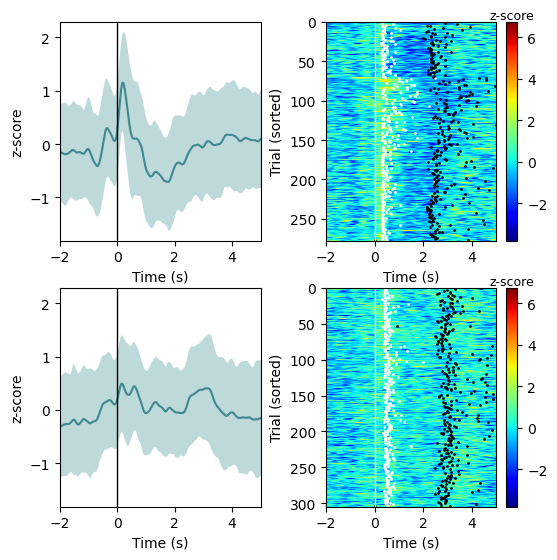

In [170]:
heat_map_and_mean(test, xlims=[-2,5])

In [ ]:
mouse = 'SNL_photo19'
date = '20200302'
saving_folder = 'W:\\photometry_2AC\\processed_data\\' + mouse + '\\'
aligned_filename = mouse + '_' + date + '_' + 'aligned_traces.p'
save_filename = saving_folder + aligned_filename
example_session_data = pickle.load(open(save_filename, "rb"))

In [137]:
example_choice_data = example_session_data.choice_data
example_reward_data = example_session_data.reward_data
example_cue_data = example_session_data.cue_data

In [138]:
from utils.plotting import heat_map_and_mean


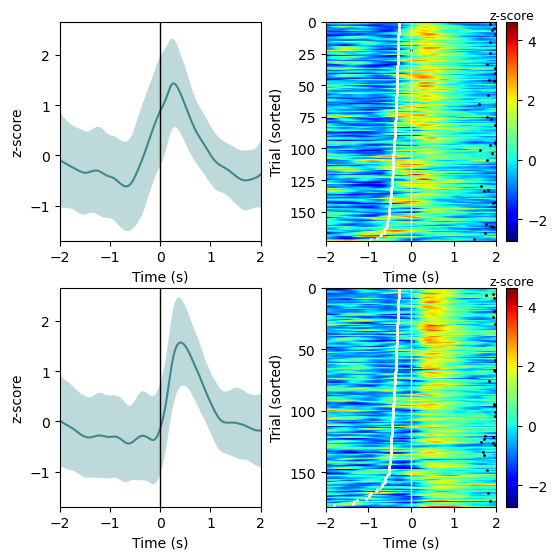

In [139]:
heat_map_and_mean(example_reward_data, sort=True, error_bar_method='sem',xlims=[-2,2])

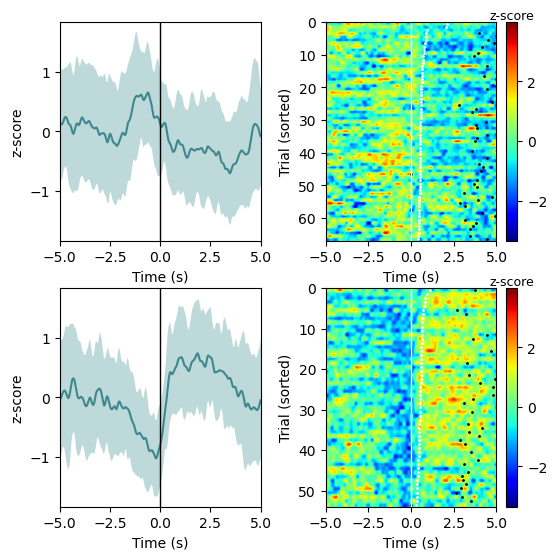

In [28]:
heat_map_and_mean(example_choice_data, sort=True, error_bar_method='sem', xlims=[-5,5])

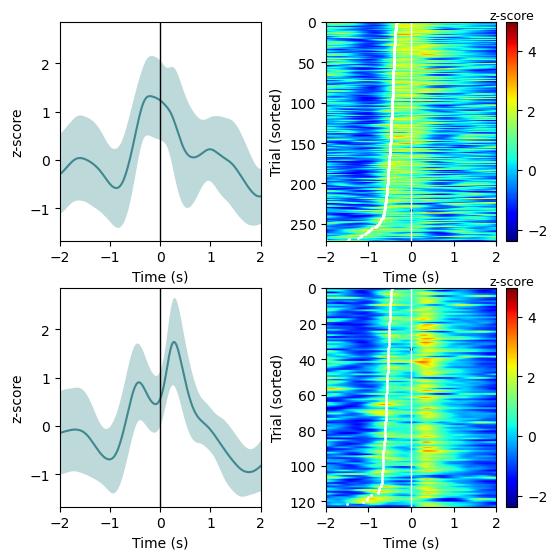

In [27]:
heat_map_and_mean(example_reward_data, sort=True, error_bar_method='sem')